# LGT1 Unit07 Day03 - In-Class: Determining PDFs from a Lattice QCD Inverse Problem with Machine Learning

### Assignment Goals

The goals of this assignment are to:

* Build and train a convolutional neural network (CNN) to predict PDFs from lattice data.
* Tune hyperparameters of the CNN to find the best validation accuracy.
* Connect the machine learning concepts we've been learning throughout Unit07 to a practical physics problem.  

### Assignment Instructions

Complete the tasks throughout this assignment and upload your notebook to Gradescope at the end of class.

In [ ]:
# You will need this to display plots with latex in google colab
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In previous notebooks

In [ ]:
# import standard python modules
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'
# import modules from SciKit-Learn
from sklearn import metrics
# import modules from TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, Dropout, MaxPooling1D, InputLayer
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

Allow colab to connect to your GoogleDrive by running the cell of code below. This will allow us to read and write data to GoogleDrive from Colab.

In [ ]:
# allow colab to connect to your drive...
# we will use this to read and write data.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


---
# Part 0: A Quick Recap
As a quick recap from your pre-class lecture, we will use the pseudo-PDF matching relation to generate the data for training our CNN:

$$ \tag{1}
\mathcal{M}(\nu = z \cdot P_z, z^2) = \int_0^1 dx \; \frac{x g(x, \mu^2)}{\langle x \rangle_g (\mu^2)} R_{gg}(\nu x, \mu^2 z^2)
$$

Here, $\nu = z \cdot P_z$, is referred to as the Ioffe-time, $xg(x, \mu^2) / \langle x \rangle_g(\mu^2)$ is the normalized gluon PDF, and $R_{gg}(\nu x, \mu^2 z^2)$ is the matching kernel dervied from perturbative QCD. We will not delve into the details of the kernel in this lecture, but interested students can refer to the literature for more information:
* [Radyushkin, PRD 96:034025 (2017)](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.96.034025)
* [Balitsky, et al., PLB 808:135621 (2020)](https://scoap3-prod-backend.s3.cern.ch/media/files/55734/10.1016/j.physletb.2020.135621.pdf)

For generating training data, we will sample from the empirical PDF model

$$ \tag{2}
\frac{xg(x,\mu^2)}{\langle x \rangle_g(\mu^2)} = x^\alpha (1-x)^\beta (1 + \gamma x + \delta \sqrt{x})
$$

by varying the parameters ($\alpha$, $\beta$, $\gamma$, $\delta$), which will allow us to produce a broad set of pseudo-PDFs for training our CNN.

---
# Part 1: Training a Convolutional Neural Network (CNN)


**Read In and Split the Training Data**

First, please download the data from our class github using [this link!](https://github.com/lgt4hep/lgt4hep_course_F25S26/blob/main/Unit07/LGT1-Unit07-Day3-IC-data.zip)
In the cell below, we read in the training data which consists of:
* `input.npy`: this contains the RpITDs!
* `output.npy`: this contains the PDFs!

Recall that when we're training a machine learning model, we want to divide our data into two separate groups. The first group is what the model will actually train on, and the second group is used for testing, which will allow us to evaluate how well our model can perform on data it's never seen before once it's fully trained. We will use a $67/33$ split (so $67\%$ is reserved for training and $33\%$ is reserved for testing).


Before we feed the data into the CNN, we normalize (scale) both the input and output values. Scaling is important because it ensures that all features are on a similar numerical range, which helps the model train faster and more reliably:
* **Input scaling**: Each of the $35$ input features in $x$ is adjusted to have a mean of $0$ and a standard deviation of $1$. This prevents features with larger numerical ranges from dominating the learning process.
* **Output scaling**: The PDF values in $y$ are also standardized to have mean $0$ and standard deviation $1$. Even though these are the target values, scaling them helps the optimizer converge more efficiently during training.

Finally, we reshape the input data to the format expected by a 1D CNN: `(batch_size, length, channels)`. Here, `length` is $35$ (the number of input features), and channels is $1$ because each feature is a single value. After reshaping, we split the normalized data into training and testing sets according to the $67/33$ ratio described above.

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# read in the data
x = np.load('input.npy')  # shape (N samples, 35 input features)
y = np.load('output.npy') # shape (N samples, 100)

# Input Scaler: normalize each of the 35 input features
x_scaler = StandardScaler()
x_norm = x_scaler.fit_transform(x)

# Output Scaler: normalize the PDF values
y_scaler = StandardScaler()
y_norm = y_scaler.fit_transform(y)

# reshape for CNN: (batch, length, channels)
x_norm = x_norm.reshape((x_norm.shape[0], x_norm.shape[1], 1))

# split the data (67/33)
x_train, x_test, y_train, y_test = train_test_split(x_norm, y_norm, test_size=0.33, random_state=0)

## 1.0 Building the CNN Model

In this section, we define the 1D convolutional neural network (CNN) that will learn the mapping from RpITDs (length 35) to PDFs (length 99). Although CNNs are often associated with image classification, they can also be useful for 1D structured data—such as signals, time-series, and the physics inputs we’re working with here...

In [ ]:
# define the CNN model...
def build_cnn(input_length):
    model = Sequential([
        # --- Input layer ---
        # Reshapes each sample to (35, 1), treating the 35 inputs as a 1D "signal".
        InputLayer(input_shape=(input_length, 1)),

        # --- Convolutional Block 1 ---
        # Learns local patterns across neighboring RpITD points (kernel size = 7).
        Conv1D(64, kernel_size=7, padding='same', activation='relu'),
        # Normalizes activations to stabilize and speed up training.
        BatchNormalization(),
        # A second convolution to extract higher-level features at the same resolution.
        Conv1D(64, kernel_size=7, padding='same', activation='relu'),
        # Normalizes activations to stabilize and speed up training.
        BatchNormalization(),
        # Downsamples the feature map by a factor of 2 to reduce complexity / noise.
        MaxPooling1D(2),

        # --- Convolutional Block 2 ---
        # Learns more complex features using more filters (128).
        Conv1D(128, kernel_size=7, padding='same', activation='relu'),
        # Normalizes activations to stabilize and speed up training.
        BatchNormalization(),
        # A second convolution to refine the learned features.
        Conv1D(128, kernel_size=7, padding='same', activation='relu'),
        # Normalizes activations to stabilize and speed up training.
        BatchNormalization(),
        # Downsamples again, reducing the sequence length further.
        MaxPooling1D(2),

        # --- Convolutional Block 3 ---
        # Uses dilation to expand the receptive field (captures longer-range correlations).
        Conv1D(256, kernel_size=5, dilation_rate=2, padding='same', activation='relu'),
        # Normalizes activations to stabilize and speed up training.
        BatchNormalization(),
        # Randomly "turns off" 15% of activations to prevent overfitting.
        Dropout(0.15),

        # --- Global Feature Aggregation ---
        # Collapses the sequence dimension by averaging each feature map.
        # Produces one feature vector per sample.
        GlobalAveragePooling1D(),

        # --- Fully Connected Layers (Mapping to PDFs) ---
        # Dense layer to combine extracted features into a high-level representation.
        Dense(256, activation='relu'),
        Dropout(0.20), # more regularization
        # Intermediate layer before the output.
        Dense(128, activation='relu'),
        # Final output layer: predicts the 99 PDF points.
        Dense(99, activation='linear')
    ])

    # Compile with MSE loss (regression task) and Adam optimizer.
    model.compile(optimizer=Adam(1e-3), loss='mse', metrics=['mse'])
    return model

Now that we've defined our CNN, let's take a look at the layers... Recall from our previous class that you can access this information through the `summary()` function.

In [ ]:
cnn_model = build_cnn(x_norm.shape[1]) # build your model
cnn_model.summary()                    # get the summary

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 35, 64)         │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 35, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 35, 64)         │        28,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 35, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 17, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 17, 128)        │        57,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 17, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 17, 128)        │       114,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 17, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 8, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 8, 256)         │       164,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 8, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 99)             │        12,771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,651 (1.83 MB)

 Trainable params: 478,371 (1.82 MB)

 Non-trainable params: 1,280 (5.00 KB)

Last class, we explored several core layer types in convolutional neural networks, such as `Dense`, `Conv1D`, and `MaxPooling1D`, using the MNIST dataset. In the model we’re working with today, you’ll notice two additional layers that we did not discuss previously: `BatchNormalization` and `Dropout`. These layers play important roles in stabilizing and improving training. Read more about each of them below.

**Dense Layer**
* A `Dense` layer (also called a fully connected layer) connects every input value to every output value.
It is typically used at the end of a CNN to combine all extracted features and produce the final prediction. Each neuron computes a weighted sum of all inputs and applies an activation function (usually relu for hidden layers). Dense layers are powerful but prone to overfitting if used too early, which is why CNNs delay using them until after feature extraction.

**Conv1D Layer**
* A `Conv1D` layer applies a set of 1-dimensional filters (kernels) that slide along the input sequence. In this assignment, the input is a length-$35$ sequence (an RpITD), not a 2D image. Filters detect local correlations and patterns in neighboring points—for example, smoothness, curvature, or shape changes in the RpITD. Each filter produces a “feature map” describing where that pattern appears in the input. We apply an activation (here, ReLU) to introduce non-linearity so the network can learn complex relationships.

**MaxPooling1D Layer**
* A `MaxPooling1D` layer reduces the size of the feature map by taking the maximum value over small segments. Why do this? For a couple of reasons: It makes the model smaller and faster, it helps prevent overfitting, and it encourages the model to focus on the strongest, most important features rather than noise. In our model, pooling halves the sequence length each time.

**BatchNormalization Layer**
* The `BatchNormalization`layer rescales and recenters the outputs of a layer so they have roughly zero mean and unit variance. This helps stabilize training, speed up learning, and reduce the risk of poor local minima. BatchNorm also learns two extra parameters (gamma and beta) that allow the network to adjust the scale and shift if needed. During training, it uses statistics from each batch, while during inference it uses averaged statistics collected during training, ensuring consistent predictions. You can think of it as keeping each layer’s outputs “well-behaved” so the network can focus on learning patterns rather than adjusting for unstable values.

**Dropout Layer**
* The `Dropout` layer randomly turns off a fraction of neurons during training (e.g., $15\%$ or $20\%$). This prevents the model from relying too heavily on any one neuron, encourages redundancy, and improves generalization. Note that during testing, dropout is automatically turned off, and all neurons are used.

### Task 1: Dropout as a Regularizer
Recall that dropout randomly “turns off” neurons during training.
Using the [Keras documentation](https://keras.io/api/layers/regularization_layers/dropout/) and the information provided above, answer the following:
* What problem does dropout prevent in neural networks?
* Why is dropout only applied during training and not during evaluation?
* What does the dropout rate represent?
* Would increasing dropout from 0.15 to 0.5 make training easier or harder? Explain.

Record your answers in the Markdown cell below.

[your answers here]

### Task 2: Batch Normalization
`BatchNormalization` is used multiple times in our CNN. Using the [Keras documentation](https://keras.io/api/layers/normalization_layers/batch_normalization/) and the information provided above, answer the following:
* What does `BatchNormalization` compute during training?
* Why does it help stabilize and speed up learning?
* What extra parameters does a BatchNorm layer learn?

Record your answers in the Markdown cell below.

[your answers here]

## 1.1 Training the CNN Model

To help monitor performance during training, we'll use a few callback functions...

**Early Stopping**
* This stops training early if the validation loss stops improving for a certain number of epochs (here, `patience=12`). It helps prevent overfitting and saves time by not training unnecessarily once the model stops improving. The option `restore_best_weights=True` ensures the model keeps the weights from the epoch with the best validation loss.

**ReduceLROnPlateau**
*  If the validation loss stops improving for a few epochs (`patience=4`), this callback reduces the learning rate by a factor (`factor=0.5`). A smaller learning rate can help the optimizer make finer adjustments and reach a better minimum. The `min_lr` parameter ensures the learning rate doesn’t become too small.

Together, these callbacks make training more efficient and stable, helping the model converge better without wasting time or overfitting.

In [ ]:
# add callback functions
callbacks = [EarlyStopping(monitor='val_loss', patience=12, restore_best_weights=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6)]

### Task 3: Understanding Early Stopping
Considering the information above, answer the following:
* What does `patience` mean in the context of `EarlyStopping`?
* What could happen if we set patience too low or too high?
* Why might it be useful to set `restore_best_weights=True`?

Record your answers in the Markdown cell below.

[your answers here]

### Task 4: Understanding ReduceLROnPlateau
* What is the purpose of reducing the learning rate when training slows down?
* What does the factor parameter control?
* Why do we set a `min_lr`? What could happen if we let the learning rate get too small?
* How might this callback interact with `EarlyStopping` during training?

Record your answers in the Markdown cell below.

[your answers here]

In [ ]:
# train the CNN Model
history = cnn_model.fit(x_train, y_train,
                        epochs=20,
                        batch_size=64,
                        validation_split=0.1,
                        callbacks=callbacks)

Epoch 1/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 9s 119ms/step - loss: 0.9339 - mse: 0.9339 - val_loss: 0.8216 - val_mse: 0.8216 - learning_rate: 0.0010
Epoch 2/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 10s 112ms/step - loss: 0.5911 - mse: 0.5911 - val_loss: 0.7786 - val_mse: 0.7786 - learning_rate: 0.0010
Epoch 3/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.6045 - mse: 0.6045 - val_loss: 0.7069 - val_mse: 0.7069 - learning_rate: 0.0010
Epoch 4/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 95ms/step - loss: 0.6093 - mse: 0.6093 - val_loss: 0.8448 - val_mse: 0.8448 - learning_rate: 0.0010
Epoch 5/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 114ms/step - loss: 0.5144 - mse: 0.5144 - val_loss: 0.7290 - val_mse: 0.7290 - learning_rate: 0.0010
Epoch 6/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 96ms/step - loss: 0.4775 - mse: 0.4775 - val_loss: 0.5945 - val_mse: 0.5945 - learning_rate: 0.0010
Epoch 7/20
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 111ms/step - loss: 0.4949 - mse: 0.4949 - val_loss: 0.4785 - val_mse: 0.4785 - learning_rate: 0.0010
Epoch 8/

## 1.2 Testing Our Trained Model
Now that we've trained our CNN model, we want to evaluate it's performance on unseen data. Let's take a look at the Mean Square Error (MSE) for the training and testing data in the cell below.

In [ ]:
train_mse = cnn_model.evaluate(x_train, y_train, verbose=0)[1]
test_mse  = cnn_model.evaluate(x_test,  y_test,  verbose=0)[1]

print(f"Train MSE = {train_mse}")
print(f"Test  MSE = {test_mse}")

Train MSE = 0.5147511959075928
Test  MSE = 0.47659188508987427


### Task 5: Model Evaluation
Compare the training and test MSE. What does it tell you about the model? Is it overfitting, underfitting, or generalizing well? Record your answers in the Markdown cell below.

[your answers here]

In the cell below, we create a plot of the training and validation loss over each epoch. This allows us to visually monitor how well the model is learning. If the training loss keeps decreasing but the validation loss starts increasing, it could indicate overfitting. If both losses plateau at high values, the model might be underfitting. By examining these curves, we can decide whether to adjust the model architecture, change hyperparameters, or apply regularization techniques to improve performance.

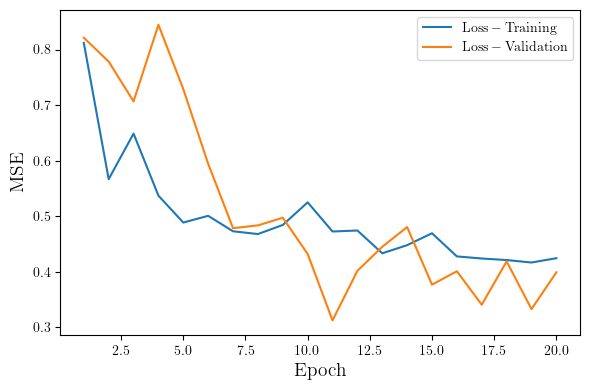

In [ ]:
# extract the loss values from the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# plot the training and validation loss
plt.figure(figsize=(6,4))
plt.plot(epochs, train_loss, label=r'$\rm Loss - Training$')
plt.plot(epochs, val_loss,   label=r'$\rm Loss - Validation$')
plt.xlabel(r'$\rm Epoch$', fontsize=14)
plt.ylabel(r'$\rm MSE$',   fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

### Task 6: Plotting and Evaluating Predicted PDFs
Select a few random test samples and use the trained CNN to predict the corresponding PDFs. For each sample, plot the predicted PDF alongside the true PDF. How well does the model perform across different values of $x$ and different samples? What does this mean? Record your answers in the Markdown cell below.

[your answers here]

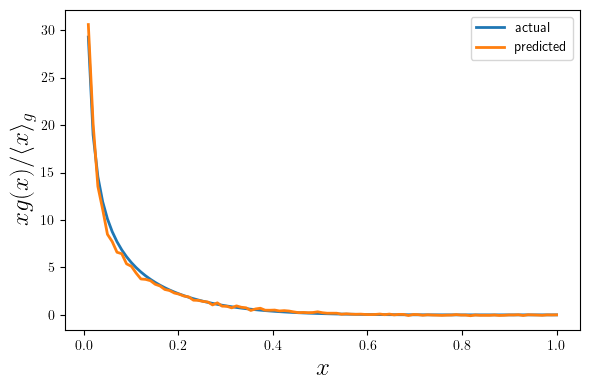

In [ ]:
# pick a sample from the test set
sample = 1000   # choose any index between 0 and len(x_test)-1

# get the normalized test input
x_sample = x_test[sample].reshape(1, -1, 1)

# predict (still in normalized PDF space)
xgx_pred_norm = cnn_model.predict(x_sample, verbose=0)[0]

# un-normalize the prediction back to physics units
xgx_pred = y_scaler.inverse_transform(xgx_pred_norm.reshape(1, -1))[0]

# true PDF for this test example, also un-normalized
xgx_true_norm = y_test[sample].reshape(1, -1)
xgx_true = y_scaler.inverse_transform(xgx_true_norm)[0]

xs = np.linspace(0.01, 1, 99)

plt.figure(figsize=(6,4))
plt.plot(xs, xgx_true, label='actual', linewidth=2)
plt.plot(xs, xgx_pred, label='predicted', linewidth=2)
plt.xlabel(r'$x$', fontsize=18)
plt.ylabel(r'$xg(x)/\langle x\rangle_g$', fontsize=18)
plt.legend()
# plt.semilogy() # note: you can uncomment this to plot on a logarithmic scale
plt.tight_layout()
plt.show()


---
# Part 2: Discussion
In this notebook, we implemented a simple 1D convolutional neural network to map RpITDs to PDFs using pseudo-data. While the CNN produces reasonable predictions in some regions, it clearly struggles in others, especially compared to the performance we saw with the MNIST dataset. This highlights an important lesson: inverse problems are inherently challenging, and machine learning models need to be carefully designed and tailored for the specific problem you are trying to solve. Choices such as network architecture, amount of training data, input preprocessing, and output scaling all significantly impact performance.

### Task 7: Final Considerations
Think about the performance of the CNN on MNIST versus the lattice QCD problem. Why does the same architecture work so well for MNIST but struggle with predicting PDFs from RpITDs? What does this tell you about the differences between typical image recognition tasks and physics inverse problems, especially in terms of data complexity, input structure, and the difficulty of the underlying mapping?

[your comments here]

---
# End of Assignment!
Please submit this notebook to GradeScope after class, and congratulations on finishing your first course in Lattice Gauge Theory!